# Import necessary libraries

In [17]:
import cv2
import dlib
import numpy as np
import os
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt # Import matplotlib for plotting
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer

# preprocessing images for better understanding

In [7]:
SOURCE_DATASET_DIR = r"C:\Users\hp\.vscode\FinalProjectFolder\FaceRecognitionSystem\dataset"
PREPROCESSED_DATASET_DIR = "preprocessed_dataset" # New directory for processed images, relative to where the script is run

# Preprocessing Parameters
TARGET_FACE_SIZE_PX = 160 # Target size for the face region after detection, for consistency
                          # This is a heuristic. dlib's model works well with ~150x150 faces.
                          # We'll try to ensure detected faces are at least this big.

def preprocess_image(image_path):
    """
    Loads an image, applies preprocessing steps, and returns the processed image.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"  Warning: Could not load image {image_path}. Skipping preprocessing.")
        return None

    # 1. Convert to Grayscale for some operations (e.g., CLAHE)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for contrast enhancement
    # This is very effective for images with varying lighting conditions.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_img = clahe.apply(gray_img)

    # Convert back to BGR for display/saving, or keep grayscale if only for detection
    # For dlib's embedding, we'll convert to RGB later.
    processed_img = cv2.cvtColor(enhanced_img, cv2.COLOR_GRAY2BGR)

    # Optional: Sharpening (uncomment to enable)
    # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    # processed_img = cv2.filter2D(processed_img, -1, kernel)

    # Optional: Noise Reduction (uncomment to enable)
    # processed_img = cv2.fastNlMeansDenoisingColored(processed_img, None, 10, 10, 7, 21)

    return processed_img

def run_preprocessing():
    """
    Iterates through the source dataset, preprocesses images, and saves them
    to a new preprocessed dataset directory.
    """
    print("--- Starting Image Preprocessing ---")
    print(f"Source: {SOURCE_DATASET_DIR}")
    print(f"Destination: {PREPROCESSED_DATASET_DIR}")

    # Create the preprocessed dataset directory structure
    os.makedirs(PREPROCESSED_DATASET_DIR, exist_ok=True)

    for person_name in os.listdir(SOURCE_DATASET_DIR):
        source_person_dir = os.path.join(SOURCE_DATASET_DIR, person_name)
        dest_person_dir = os.path.join(PREPROCESSED_DATASET_DIR, person_name)

        if not os.path.isdir(source_person_dir):
            continue

        os.makedirs(dest_person_dir, exist_ok=True)
        print(f"Processing images for: {person_name}")

        for filename in os.listdir(source_person_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                source_image_path = os.path.join(source_person_dir, filename)
                dest_image_path = os.path.join(dest_person_dir, filename)

                processed_img = preprocess_image(source_image_path)

                if processed_img is not None:
                    # Save the preprocessed image
                    cv2.imwrite(dest_image_path, processed_img)
                    # print(f"  Processed and saved: {filename}")

    print("\n--- Image Preprocessing Complete ---")
    print(f"You can now point your model_evaluation.ipynb to '{PREPROCESSED_DATASET_DIR}'")

if __name__ == "__main__":
    run_preprocessing()

--- Starting Image Preprocessing ---
Source: C:\Users\hp\.vscode\FinalProjectFolder\FaceRecognitionSystem\dataset
Destination: preprocessed_dataset
Processing images for: Altar
Processing images for: Barack
Processing images for: Kelvin
Processing images for: Osayi
Processing images for: Victor

--- Image Preprocessing Complete ---
You can now point your model_evaluation.ipynb to 'preprocessed_dataset'


#  Configuration 

In [ ]:

# Directory where your worker images are stored
DATASET_DIR = r"C:\Users\hp\.vscode\FinalProjectFolder\FaceRecognitionSystem\preprocessed_dataset"  

# Directory where dlib models are stored
MODELS_DIR = r"C:\Users\hp\.vscode\FinalProjectFolder\FaceRecognitionSystem\models"   

# NEW: Directory for your separate test images (known and unknown)
TEST_DATASET_DIR = r"C:\Users\hp\.vscode\FinalProjectFolder\FaceRecognitionSystem\test_dataset"    

# File to save the known face encodings and names
ENCODINGS_FILE = "encodings.pkl" 
# TOLERANCE for evaluation. This is the threshold for considering faces a match.
# You can adjust this value to see how it affects accuracy.
EVALUATION_TOLERANCE = 0.6 # This will be the default for the text output, but plots will sweep



#  Load dlib Models 

In [10]:

print("Loading dlib models...")
try:
    detector = dlib.get_frontal_face_detector()
    predictor_path = os.path.join(MODELS_DIR, "shape_predictor_68_face_landmarks.dat")
    predictor = dlib.shape_predictor(predictor_path)
    face_recognizer_path = os.path.join(MODELS_DIR, "dlib_face_recognition_resnet_model_v1.dat")
    face_recognizer = dlib.face_recognition_model_v1(face_recognizer_path)
    print("dlib models loaded successfully.")
except Exception as e:
    print(f"Error loading dlib models. Make sure '{MODELS_DIR}' directory exists and contains the .dat files.")
    print(f"Error: {e}")
    exit() # Exit if models cannot be loaded, as they are essential

Loading dlib models...
dlib models loaded successfully.


# Helper Function to Get Face Encoding 

In [ ]:
def get_face_encoding(image_path):
    """
    Loads an image, detects faces, selects the largest one if multiple are found,
    and returns its 128D encoding.
    Returns None if no face is found.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"    Warning: Could not load image {image_path}. Skipping.")
        return None, None

    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected_faces = detector(rgb_image, 1) # Upsample for better detection

    if len(detected_faces) == 0:
        # print(f"    Warning: No face found in {os.path.basename(image_path)}. Skipping.")
        return None, None
    elif len(detected_faces) > 1:
        # MODIFICATION START
        # If multiple faces are found, select the largest one
        largest_face = None
        max_area = 0
        for face in detected_faces:
            area = face.area() # dlib.rectangle has an area() method
            if area > max_area:
                max_area = area
                largest_face = face
        face_rect = largest_face
        # print(f"    Info: Multiple faces found in {os.path.basename(image_path)}. Using the largest face.")
        # MODIFICATION END
    else: # Exactly one face detected
        face_rect = detected_faces[0]

    if face_rect is None: # Should not happen if detected_faces was not empty, but a safety check
        return None, None

    shape = predictor(rgb_image, face_rect)
    face_encoding = np.array(face_recognizer.compute_face_descriptor(rgb_image, shape))
    return face_encoding, face_rect # Return face_rect for potential future use (e.g., cropping)

# Generate Known Face Encodings (Enrollment)

In [20]:
# This part processes the training dataset
print(f"\nGenerating and saving known face encodings from '{DATASET_DIR}'...")
known_face_encodings = []
known_face_names = []

for person_name in os.listdir(DATASET_DIR):
    person_dir = os.path.join(DATASET_DIR, person_name)
    if not os.path.isdir(person_dir):
        continue

    print(f"  Processing images for: {person_name}")
    for filename in os.listdir(person_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(person_dir, filename)
            encoding, _ = get_face_encoding(image_path) # We don't need face_rect for enrollment here

            if encoding is not None:
                known_face_encodings.append(encoding)
                known_face_names.append(person_name)
            else:
                print(f"    Skipping {filename} for {person_name} due to no/multiple faces detected.")

print(f"\nFinished generating {len(known_face_encodings)} known face encodings.")
print(f"Total unique workers enrolled: {len(set(known_face_names))} workers.")


Generating and saving known face encodings from 'C:\Users\hp\.vscode\FinalProjectFolder\FaceRecognitionSystem\preprocessed_dataset'...
  Processing images for: Altar
    Skipping altar_17.JPG for Altar due to no/multiple faces detected.
    Skipping altar_20.JPG for Altar due to no/multiple faces detected.
  Processing images for: Barack
  Processing images for: Kelvin
  Processing images for: Osayi
    Skipping osayi_12.jpg for Osayi due to no/multiple faces detected.
  Processing images for: Victor
    Skipping victor_12.jpg for Victor due to no/multiple faces detected.
    Skipping victor_5.jpg for Victor due to no/multiple faces detected.

Finished generating 117 known face encodings.
Total unique workers enrolled: 5 workers.


# Save the encodings and names

In [21]:
try:
    with open(ENCODINGS_FILE, 'wb') as f:
        pickle.dump({"encodings": known_face_encodings, "names": known_face_names}, f)
    print(f"\nKnown face encodings and names saved to '{ENCODINGS_FILE}'.")
except Exception as e:
    print(f"Error saving encodings to '{ENCODINGS_FILE}': {e}")
    exit()


Known face encodings and names saved to 'encodings.pkl'.


# Model Performance Evaluation 

# Test Dataset for Evaluation

In [27]:
print(f"\nPreparing test dataset from '{TEST_DATASET_DIR}'...")
test_encodings = []
true_labels = [] # The actual names or 'Unknown'
predicted_distances = [] # Store distances for ROC/PR curves


Preparing test dataset from 'C:\Users\hp\.vscode\FinalProjectFolder\FaceRecognitionSystem\test_dataset'...


# Load known test images

In [28]:
for person_name in os.listdir(TEST_DATASET_DIR):
    person_dir = os.path.join(TEST_DATASET_DIR, person_name)
    if not os.path.isdir(person_dir):
        continue

    # Treat 'Unknown_People' folder specially
    is_unknown_category = (person_name.lower() == "unknown_people")

    print(f"  Processing test images for: {person_name}")
    for filename in os.listdir(person_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(person_dir, filename)
            encoding, _ = get_face_encoding(image_path)

            if encoding is not None:
                test_encodings.append(encoding)
                true_labels.append("Unknown" if is_unknown_category else person_name)
            else:
                print(f"    Skipping test image {filename} for {person_name} due to no/multiple faces detected.")

print(f"Finished processing {len(test_encodings)} test images.")
print(f"Unique true labels in test set: {set(true_labels)}")


  Processing test images for: Altar
  Processing test images for: Unknown_people
  Processing test images for: Victor
Finished processing 55 test images.
Unique true labels in test set: {'Victor', 'Altar', 'Unknown'}


# Run Evaluation Across Tolerances

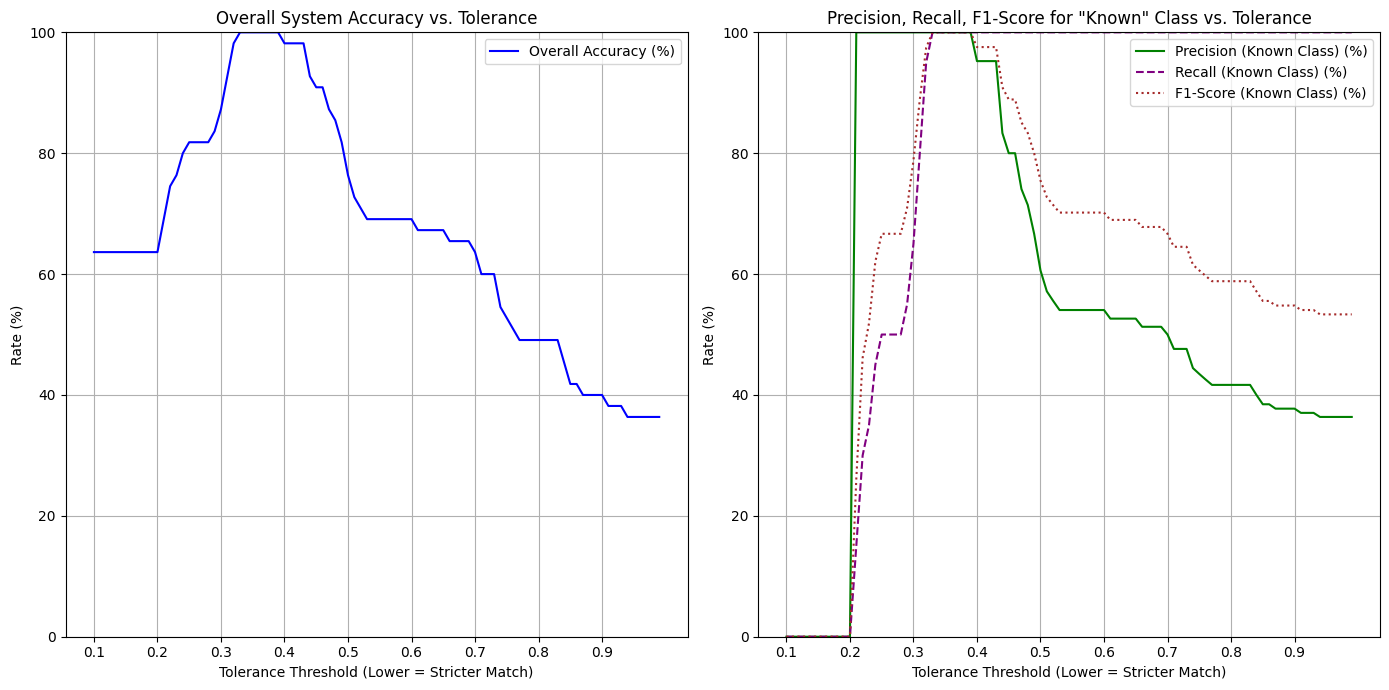

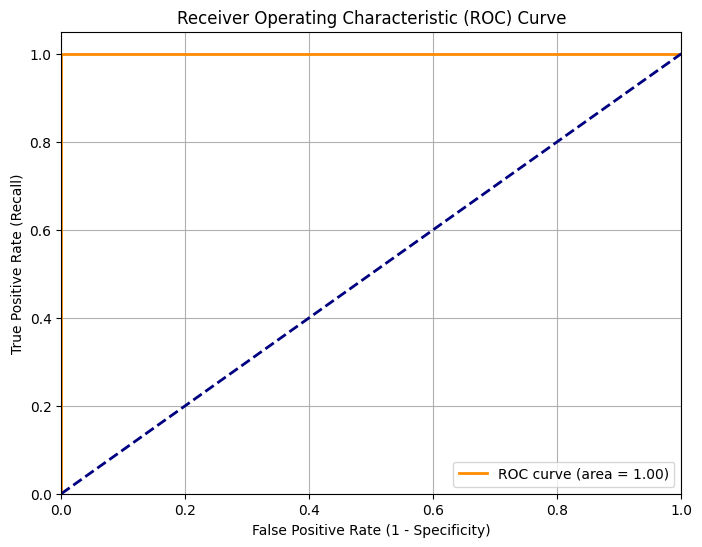


--- Confusion Matrix for Tolerance = 0.35 ---


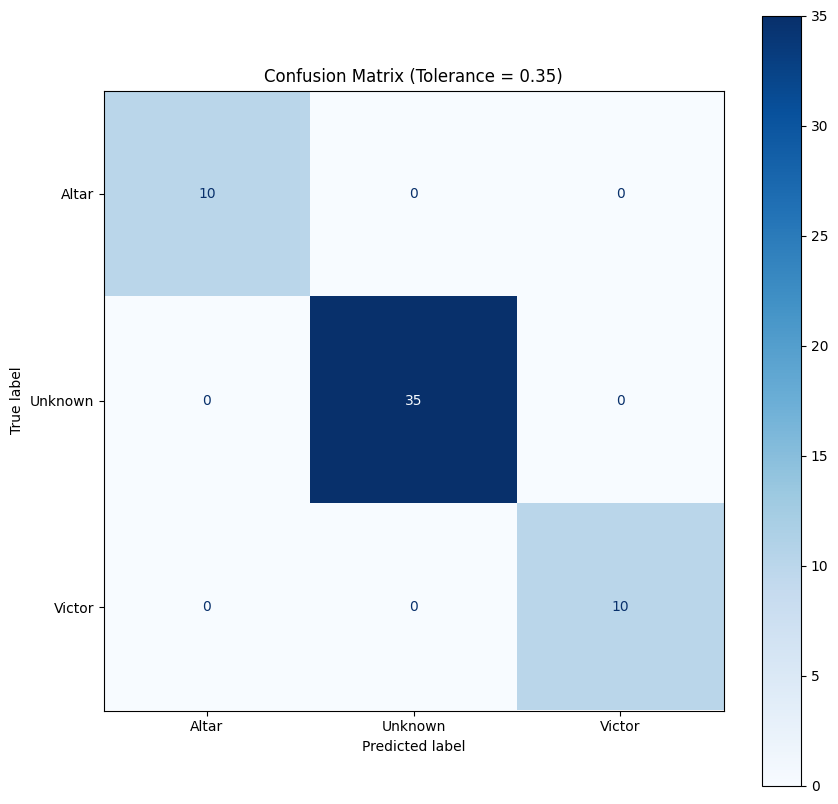


--- Evaluation Complete ---
Review the plots and confusion matrix to understand your system's performance.
The ROC curve helps visualize the trade-off between true positives and false positives.
The Confusion Matrix gives a detailed breakdown of correct/incorrect classifications for each category.


In [ ]:
if not known_face_encodings or not test_encodings:
    print("\nCannot perform evaluation: Either no known faces enrolled or no test images processed.")
else:
    tolerance_values = np.arange(0.1, 1.0, 0.01) # Fine-grained range for plots
    accuracies = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    true_positive_rates = [] # For ROC
    false_positive_rates = [] # For ROC

    # Prepare for ROC and Precision-Recall curves
    # For ROC/PR, we need binary classification: Is it a "known" person or "unknown"?
    # We will treat any known person as 'positive' and 'unknown' as 'negative'.
    # For multi-class, we'll use one-vs-rest strategy.

    # Collect all unique known names plus 'Unknown'
    all_possible_labels = sorted(list(set(known_face_names).union(set(true_labels))))
    if "Unknown" not in all_possible_labels:
        all_possible_labels.append("Unknown") # Ensure 'Unknown' is always a label

    # Binarize labels for ROC/PR curves
    lb = LabelBinarizer()
    lb.fit(all_possible_labels) # Fit on all possible labels to ensure consistency

    # Store predicted probabilities/distances for ROC/PR
    # For each test encoding, find its distance to the closest known face.
    # We'll use 1 - (distance / max_possible_distance) as a "score" for being known.
    # Or simply use the negative distance, as lower distance means higher "known-ness".
    
    # For ROC/PR, we need a score for each class.
    # Let's simplify for now: for each test image, what's the minimum distance to *any* known face?
    # This minimum distance is our "score" for being a known person (lower score = more likely known)
    # The true label for ROC/PR will be 1 if it's a known person, 0 if it's unknown.

    true_binary_labels = [] # 1 for known, 0 for unknown
    min_distances_for_roc = [] # Score for being known (lower distance = higher score)

    for i, test_encoding in enumerate(test_encodings):
        current_true_label = true_labels[i]
        
        if current_true_label != "Unknown":
            true_binary_labels.append(1) # It's a known person
        else:
            true_binary_labels.append(0) # It's an unknown person

        if known_face_encodings:
            distances = np.linalg.norm(known_face_encodings - test_encoding, axis=1)
            min_dist = np.min(distances)
            min_distances_for_roc.append(min_dist)
        else:
            min_distances_for_roc.append(float('inf')) # If no known faces, all distances are infinite


    # Convert distances to "scores" where higher score means more likely to be positive (known)
    # max_dist = np.max(min_distances_for_roc) if min_distances_for_roc else 1.0
    # scores_for_roc = 1 - (np.array(min_distances_for_roc) / max_dist) # Normalize to 0-1 range

    # For ROC/PR, a lower distance implies a higher "score" for being positive.
    # So, we can use -min_distance as the score, or simply use min_distance and adjust thresholds.
    # Let's use min_distance directly and inverse the threshold logic for plots.

    # Calculate metrics for each tolerance
    for current_tolerance in tolerance_values:
        y_pred = [] # Predicted labels ('Known' or 'Unknown')
        y_true_eval = [] # True labels for evaluation (actual names or 'Unknown')

        tp, tn, fp, fn = 0, 0, 0, 0 # For confusion matrix

        for i, test_encoding in enumerate(test_encodings):
            current_true_label = true_labels[i]
            y_true_eval.append(current_true_label)

            if known_face_encodings:
                distances = np.linalg.norm(known_face_encodings - test_encoding, axis=1)
                min_distance_idx = np.argmin(distances)
                min_distance = distances[min_distance_idx]
                
                if min_distance < current_tolerance:
                    predicted_name = known_face_names[min_distance_idx]
                else:
                    predicted_name = "Unknown"
            else:
                predicted_name = "Unknown" # If no known faces, everything is unknown

            y_pred.append(predicted_name)

            # Calculate TP, TN, FP, FN for the binary classification (Known vs Unknown)
            if current_true_label != "Unknown": # It's a known person
                if predicted_name != "Unknown": # Predicted as known (could be correct or misidentified)
                    tp += 1 # We consider any known person identified as known (even if wrong known) as a TP for "is known"
                else: # Predicted as unknown
                    fn += 1 # Known person identified as unknown
            else: # It's an unknown person
                if predicted_name == "Unknown": # Predicted as unknown
                    tn += 1 # Unknown person identified as unknown
                else: # Predicted as known
                    fp += 1 # Unknown person identified as known (False Alarm!)

        # Calculate accuracy, precision, recall, F1 for the overall system
        # Accuracy: (TP_overall + TN_overall) / Total
        # Precision: TP_overall / (TP_overall + FP_overall)
        # Recall: TP_overall / (TP_overall + FN_overall)

        # For multi-class accuracy:
        correct_overall = sum(1 for p_name, t_name in zip(y_pred, y_true_eval) if p_name == t_name)
        accuracy = correct_overall / len(y_true_eval) if len(y_true_eval) > 0 else 0
        accuracies.append(accuracy * 100)

        # Precision, Recall, F1 for the 'Known' class (positive class for alarm system)
        # Precision: Of those identified as 'Known', how many were actually 'Known'?
        # Recall: Of all actual 'Known' people, how many were identified as 'Known'?
        
        # We need to compute these carefully for the "is known" vs "is unknown" problem
        # TP: True Known (Known person correctly identified as Known, even if wrong known name)
        # TN: True Unknown (Unknown person correctly identified as Unknown)
        # FP: False Known (Unknown person incorrectly identified as Known)
        # FN: False Unknown (Known person incorrectly identified as Unknown)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precision_scores.append(precision * 100)
        recall_scores.append(recall * 100)
        f1_scores.append(f1 * 100)

    # Plotting Results
    plt.figure(figsize=(14, 7))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(tolerance_values, accuracies, label='Overall Accuracy (%)', color='blue')
    plt.xlabel('Tolerance Threshold (Lower = Stricter Match)')
    plt.ylabel('Rate (%)')
    plt.title('Overall System Accuracy vs. Tolerance')
    plt.grid(True)
    plt.legend()
    plt.xticks(np.arange(0.1, 1.0, 0.1))
    plt.ylim(0, 100)

    # Plot Precision, Recall, F1-Score for the "Known" class
    plt.subplot(1, 2, 2)
    plt.plot(tolerance_values, precision_scores, label='Precision (Known Class) (%)', color='green')
    plt.plot(tolerance_values, recall_scores, label='Recall (Known Class) (%)', color='purple', linestyle='--')
    plt.plot(tolerance_values, f1_scores, label='F1-Score (Known Class) (%)', color='brown', linestyle=':')
    plt.xlabel('Tolerance Threshold (Lower = Stricter Match)')
    plt.ylabel('Rate (%)')
    plt.title('Precision, Recall, F1-Score for "Known" Class vs. Tolerance')
    plt.grid(True)
    plt.legend()
    plt.xticks(np.arange(0.1, 1.0, 0.1))
    plt.ylim(0, 100)

    plt.tight_layout()
    plt.show()

    # ROC Curve and AUC 
    # For ROC, we need true binary labels (1 for known, 0 for unknown) and scores (min_distance_for_roc)
    # Note: For ROC, a higher score means more confident positive. Here, lower distance means more confident positive.
    # So, we should use -min_distances_for_roc as scores, or invert the threshold comparison in roc_curve.
    # Let's use -min_distances_for_roc as scores.
    if len(true_binary_labels) > 1 and len(set(true_binary_labels)) > 1: # Need at least two classes for ROC
        scores_for_roc = -np.array(min_distances_for_roc) # Invert distances so higher score is better match

        fpr, tpr, thresholds = roc_curve(true_binary_labels, scores_for_roc)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Recall)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    else:
        print("\nSkipping ROC Curve: Not enough diverse samples (known/unknown) in test set.")

    # Confusion Matrix for Optimal Tolerance (e.g., 0.6)
    # Re-run prediction for a chosen optimal tolerance for the confusion matrix
    optimal_tolerance = 0.35 # change this after analyzing the plots
    print(f"\nConfusion Matrix for Tolerance = {optimal_tolerance}")

    y_true_cm = []
    y_pred_cm = []

    for i, test_encoding in enumerate(test_encodings):
        current_true_label = true_labels[i]
        y_true_cm.append(current_true_label)

        if known_face_encodings:
            distances = np.linalg.norm(known_face_encodings - test_encoding, axis=1)
            min_distance_idx = np.argmin(distances)
            min_distance = distances[min_distance_idx]
            
            if min_distance < optimal_tolerance:
                predicted_name = known_face_names[min_distance_idx]
            else:
                predicted_name = "Unknown"
        else:
            predicted_name = "Unknown"

        y_pred_cm.append(predicted_name)
    
    # Ensure all possible labels are in the confusion matrix, including 'Unknown'
    cm_labels = sorted(list(set(y_true_cm).union(set(y_pred_cm))))
    if "Unknown" not in cm_labels:
        cm_labels.append("Unknown")
    
    cm = confusion_matrix(y_true_cm, y_pred_cm, labels=cm_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(f'Confusion Matrix (Tolerance = {optimal_tolerance})')
    plt.show()

    print("\nEvaluation Complete")
    print("A Review of the plots and confusion matrix will help understand the system's performance.")
    print("The ROC curve helps visualize the trade-off between true positives and false positives.")
    print("The Confusion Matrix gives a detailed breakdown of correct/incorrect classifications for each category.")
